## Final Project Submission

You'll clean, explore, and model this dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible.

* Student name: Caitlin Snyder
* Student pace: self-paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: https://caitlinsnyder.medium.com/predicting-water-point-functionality-in-tanzania-6e566c0ff18a?postPublishedType=initial



# 1) Introduction

As I wrap up Module 3 of Flat Iron's Data Science bootcamp, I will be tacking a Driven Data competition, [Pump It Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/).

Follow along below, or take a look at the [Jupyter notebook and repo on GitHub](https://github.com/caitsnyder/module_3_project).

The competition provides a dataset of water points in Tanzania and their associated characteristics. It is our job to predict, using the supplied training labels, whether a pump is functional, non-functional, or functional but in need of repair.


In the below, I'll be building a model to predict water point status given a testing dataset. Let's get started!

In [1]:
import sys
import re
import os
import pathlib

from google.colab import drive
drive.mount('/content/gdrive')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as tts

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler

# !{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier


Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 2) Define the relevant classes

I'll be taking an object-oriented approach to this project and will begin by defining the classes and constants I'll need.

## A) Accessing the data

### Paths
We'll define our path strings within a simple dictionary for easy loading:


In [2]:
data_folder = r'/content/gdrive/MyDrive/Colab Notebooks/Mod3/data/'

paths = {
        'train_values': pathlib.Path(data_folder + 'training_set_values.csv'),
        'train_labels': pathlib.Path(data_folder + 'training_set_labels.csv'),
        'test_values': pathlib.Path(data_folder + 'test_set_values.csv')
}


### Data Loader
The Data Loader will load the appropriate csvs. This helper class includes an option (run_type_dev) to downsample our dataset as needed:

In [3]:
class DataLoader:
    def __init__(self):
        pass

    def load(self, outcome, run_type_dev, sample_size):
        X_train = self.load_from_path(paths['train_values'])
        y_train = self.load_from_path(paths['train_labels'])
        
        if run_type_dev:
            print(f"Sample size = {sample_size}")
            X_train = X_train.iloc[0:sample_size]
            y_train = y_train.iloc[0:sample_size]
            
        df = pd.concat([X_train, y_train], axis=1, join="inner")
        self.outcome_values = np.unique(df[outcome])
        return df
    
    def load_from_path(self, path):
        df = pd.read_csv(path)
        df.set_index('id', inplace=True)
        return df
        

## B) Cleaning the data

### VizHelper
The Viz Helper will output relevant visualizations to inform iterative cleaning and analysis:

In [4]:
class VizHelper:
    def __init__(self):
        pass

    def show_visualizations(self, df, outcome):
        cont_features = df.select_dtypes(exclude=['object']).columns
        self.check_outcome_distribution(df, outcome)
        self.generate_heat_map(df, cont_features)
        self.show_outliers(df, cont_features)
        self.show_basic_correlations(df, cont_features, outcome)
        self.show_outcome_dist(df, outcome)

    def check_outcome_distribution(self, df, outcome):
        labels = df[outcome].value_counts().index
        cnts = df[outcome].value_counts().values
        
        df_temp = pd.DataFrame({'labels':labels, 'counts':cnts})
        ax = df_temp.plot.bar(x='labels', y='counts', rot=0)
        ax.set_title("Frequency of outcome values")

    def generate_heat_map(self, df, features):
        plt.figure(figsize=(7, 6))
        sns.heatmap(df[features].corr(), center=0)
        plt.show()

    def show_outliers(self, df, cols):
        fig, axes = plt.subplots(2, 3, figsize=(9, 6))
        axe = axes.ravel()

        for i, xcol in enumerate(cols):
            sns.boxplot(x=df[xcol], ax=axe[i])
        plt.show()

    def show_basic_correlations(self, df, cols, outcome):
        preds = [i for i in cols if i != outcome]
        fig, axes = plt.subplots(2, 3, figsize=(9, 6))
        axe = axes.ravel()

        for i, xcol in enumerate(preds):
            df.plot(kind='scatter', x=xcol, y=outcome, alpha=0.4, color='b', ax=axe[i])
        
        plt.show()

    def show_outcome_dist(self, df, outcome):
        df[outcome].value_counts().plot(kind='bar')

    def show_confusion_matrix(self, clf, X_test, y_test, outcome, title):
        labels = y_test[outcome].unique()
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                        display_labels=labels,
                                        cmap=plt.cm.Greens,
                                        xticks_rotation='vertical')
        disp.ax_.set_title(title)
        plt.show()


### Cleaner
Our Cleaner will perform basic cleaning tasks (eliminate impossible 0 values, correct column data types) on our raw data:

In [5]:
class Cleaner():
    def __init__(self):
        self.viz_helper = VizHelper()

    def clean_df(self, df):
        df.drop(['num_private', 'amount_tsh'], axis=1, inplace=True)
        self.convert_to_string(df)
        self.replace_nan(df)
        self.bin_date(df)
        self.bin_categorical_features(df)
        return df

    def convert_to_string(self, df):
        cols = [
            'region_code', 
            'district_code', 
            'public_meeting', 
            'permit'
        ]
        list(map(lambda col: self.change_type(df, col, str), cols))
    
    def change_type(self, df, col, new_type):
        df[col] = df[col].astype(new_type)

    def replace_nan(self, df):
        self.replace_null_strings(df, "nan")
        self.replace_null_strings(df, "none")
        self.replace_zeros(df, "longitude")
        self.replace_zeros(df, "latitude")
        self.replace_zeros(df, 'construction_year')
        self.replace_zeros(df, 'population')

    def replace_null_strings(self, df, null_str):
        df.replace(to_replace=null_str, value="unknown", inplace=True)

    def replace_zeros(self, df, col):
        df[col] = df.apply(lambda row: np.nan 
            if row[col] == 0 else row[col], axis=1)

    def bin_date(self, df):
        df['year'] = [x.split("-")[0] for x in df['date_recorded']]
        df['month'] = [x.split("-")[1] for x in df['date_recorded']]
        df.drop(['date_recorded'], axis=1, inplace=True)

    def bin_categorical_features(self, df):
        cols = df.select_dtypes(include=['object']).columns.values.tolist()
        for col in cols:
            top_10 = df[col].value_counts().index[:10].tolist()
            if len(top_10) == 10:
                df[col] = [x if x in top_10 else "Other" for x in df[col]]
                

## C) Build the pipeline

### Splits Manager
The Splits Manager will allow us to easily access our train-test datasets (without worrying about the typos that a simple dictionary access command is susceptible to): 

In [6]:
class SplitsManager:
    def __init__(self):
        self.X_train = None
        self.X_test = None, 
        self.y_train = None 
        self.y_test = None
        

### Pre-Processor
The Pre-Processor defines transformations our pipeline will use. Since our dataset is unbalanced (a histogram of our outcome variable shows that 'functional' is vastly over-represented in the dataset relative to the other two outcomes), we will oversample our minority outcomes to achieve a more balanced dataset.

In [7]:
class PreProcessor():
    def __init__(self):
        pass

    def get_preprocessor(self, df):
        return {
            'sampler': self.get_resampler(),
            'col': self.get_col_transformer(df)
            }

    def get_resampler(self):
        return RandomOverSampler(random_state=42)
        
    def get_col_transformer(self, df):
        cont_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])

        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        return ColumnTransformer(
            transformers=[
                ('num', cont_transformer, self.get_cont_features(df)),
                ('cat', cat_transformer, self.get_cat_features(df))])

    def get_cat_features(self, df):
        return df.select_dtypes(include=['object']).columns
        
    def get_cont_features(self, df):
        return df.select_dtypes(exclude=['object']).columns
    
        

### Classifiers
We can store our classifiers in a dictionary so that we can easily iterate over them during analysis:


In [8]:
classifiers = {
    # 'decision_tree': DecisionTreeClassifier(),
    # 'random_forest': RandomForestClassifier(),
    # 'knn': KNeighborsClassifier(),
    'xgboost': XGBClassifier()
}

### Param Grids
We can similarly store the corresponding param grid for each classifier in a dictionary:


In [9]:
param_grids = {
    'decision_tree': {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 2, 3, 4, 5, 6],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6]
    },
    'random_forest': {
        'clf__n_estimators': [10, 20, 30],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [5, 10, 20, 30, 35],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [2, 3, 6]
    },
    'knn': {
        'clf__n_neighbors': [3, 5, 7, 11, 19],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    'xgboost': {
        'clf__max_depth': [10],
    }
}


### Results Manager
The Report Manager will use store and organize the results:

In [10]:
class ResultsManager:
    def __init__(self, key, results, clf_report):
        self.clf_name = key.replace("_", " ").upper()
        self.best_estimator = results.best_estimator_
        self.best_score = results.best_score_
        self.best_params = results.best_params_
        self.clf_report = clf_report


### Report Manager
The Report Manager will use the shared keys in these two dictionaries to iterate over each classifier and score its performance:


In [11]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import classification_report

class ReportManager:
    def __init__(self, outcome):
        self.splits = None
        self.results = []
        self.outcome = outcome

    def run_reports(self, preprocessor, splits: SplitsManager):
        self.splits = splits
        list(map(lambda key: self.execute_pipeline(preprocessor, key), classifiers.keys()))
        list(map(lambda x: self.display_predictions(x), self.results))
        self.display_results()

    def execute_pipeline(self, preprocessor, key):
        print(f"Beginning {key}...")
        param_grid = param_grids[key]
        param_grid['col__num__imputer__strategy'] = ['mean', 'median']

        pipe = imbPipeline([
            ('col', preprocessor['col']),
            ('sampler', preprocessor['sampler']),
            ("clf", classifiers[key])
            ])
        gs = GridSearchCV(pipe,
                            param_grid,
                            cv=3,
                            scoring="accuracy",
                            n_jobs=-1
                        )
        gs_results  = gs.fit(self.splits.X_train, self.splits.y_train.values.ravel())
        y_preds = gs.predict(self.splits.X_test)
        clf_report = classification_report(self.splits.y_test, y_preds, self.splits.y_train[self.outcome].unique().tolist())
        self.results.append(ResultsManager(key, gs_results, clf_report))

    def display_results(self):
        rows = list(map(lambda x: [x.clf_name, x.best_score, x.best_params], self.results))
        df = pd.DataFrame(rows, columns=[
            'clf_name', 
            'best_score', 
            'best_params'
        ]).sort_values(by='best_score', ascending = False)
        print(df)
        print('---------\nDiagnostics\n---------')
        for result in self.results:
            print(result.clf_name.upper())
            print(f"Accuracy: {result.best_score:.2%}")
            print(f"Classification report:")
            print(result.clf_report)

    def display_predictions(self, result: ResultsManager):
        title = f"{result.clf_name} ({result.best_score:.2%})"
        VizHelper().show_confusion_matrix(result.best_estimator, self.splits.X_test, self.splits.y_test, self.outcome, title)


## D) Tying it all together

### Data Manager
The Data Manager is responsible for coordinating the different helper classes responsible for cleaning, pipeline-creation, visualization, and analysis:

In [12]:
class DataManager:
    def __init__(self, sample_size, run_type_dev=True):

        self.sample_size = sample_size
        self.outcome = 'status_group'
        self.splits = SplitsManager()
        self.process_data(run_type_dev)

    def process_data(self, run_type_dev):
        raw_df = DataLoader().load(self.outcome, run_type_dev, self.sample_size)
        df = Cleaner().clean_df(raw_df)
        VizHelper().show_visualizations(df, self.outcome)
        self.split_data(df, self.outcome)
   
    def split_data(self, df, outcome):
        X = df[[i for i in df.columns if i != outcome]]
        y = df[[outcome]]
        
        self.splits.X_train, self.splits.X_test,\
            self.splits.y_train, self.splits.y_test =\
            tts(X, y, test_size = 0.2, random_state = 42)

    def get_report(self):
        preprocessor = PreProcessor().get_preprocessor(self.splits.X_train)
        ReportManager(self.outcome).run_reports(preprocessor, self.splits)


# 3) Analyze Results & Take-aways

Now that we've defined our classes, we can kick off the analysis:

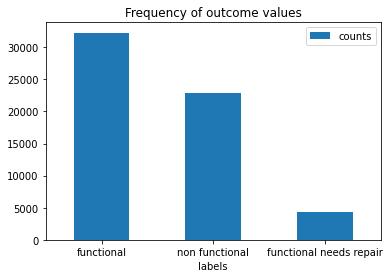

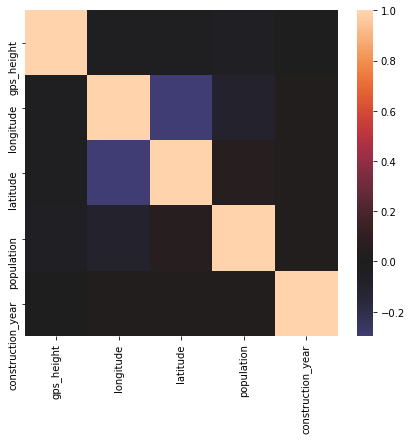

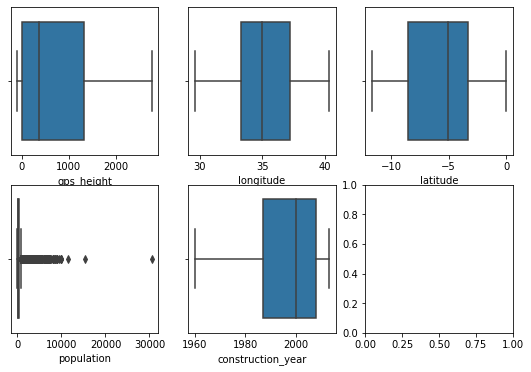

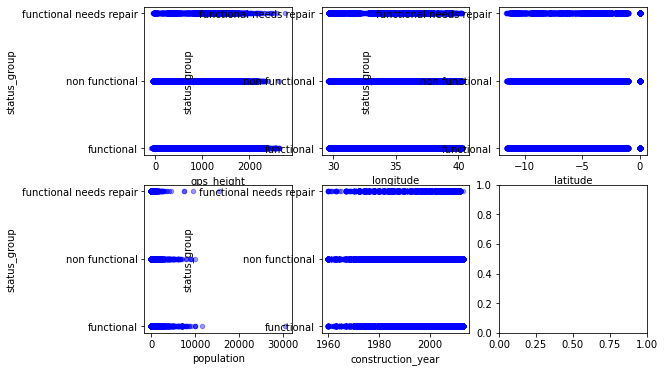

Beginning xgboost...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


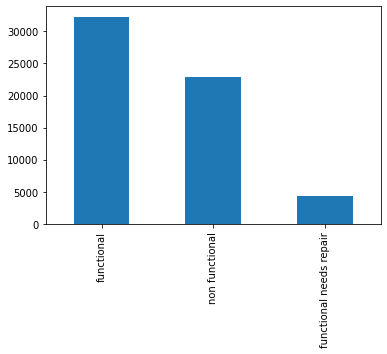

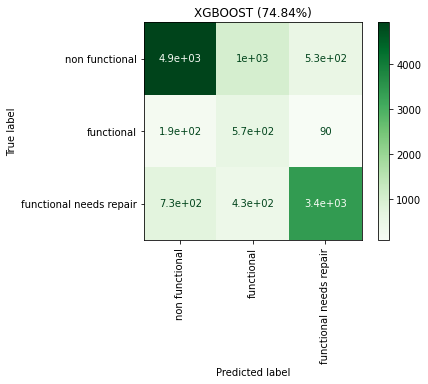

  clf_name  best_score                                        best_params
0  XGBOOST    0.748401  {'clf__max_depth': 10, 'col__num__imputer__str...
---------
Diagnostics
---------
XGBOOST
Accuracy: 74.84%
Classification report:
                         precision    recall  f1-score   support

             functional       0.84      0.76      0.80      6457
         non functional       0.85      0.75      0.79      4572
functional needs repair       0.29      0.67      0.40       851

               accuracy                           0.75     11880
              macro avg       0.66      0.73      0.66     11880
           weighted avg       0.80      0.75      0.77     11880



In [13]:
dfs = DataManager(sample_size=500, run_type_dev=False)
dfs.get_report()


Decision Tree:

In [ ]:
# Decision Tree
# Accuracy: 74.60%
# Classification report:
# ```
#                          precision    recall  f1-score   support

#              functional       0.80      0.81      0.80      6457
#          non functional       0.78      0.76      0.77      4572
# functional needs repair       0.37      0.40      0.38       851

#                accuracy                           0.76     11880
#               macro avg       0.65      0.66      0.65     11880
#            weighted avg       0.76      0.76      0.76     11880

Random Forest:

In [ ]:
# Random Forest
# Accuracy: 77.37%
# Classification report:
#                          precision    recall  f1-score   support

#              functional       0.83      0.80      0.82      6457
#          non functional       0.83      0.77      0.80      4572
# functional needs repair       0.35      0.57      0.43       851

#                accuracy                           0.77     11880
#               macro avg       0.67      0.72      0.68     11880
#            weighted avg       0.80      0.77      0.78     11880

KNN

In [ ]:
# KNN
# Accuracy: 75.08%
# Classification report:
#                          precision    recall  f1-score   support

#              functional       0.82      0.78      0.80      6457
#          non functional       0.77      0.78      0.78      4572
# functional needs repair       0.37      0.48      0.42       851

#                accuracy                           0.76     11880
#               macro avg       0.65      0.68      0.67     11880
#            weighted avg       0.77      0.76      0.77     11880

XGBoost

In [ ]:
# XGBOOST
# Accuracy: 74.84%
# Classification report:
#                          precision    recall  f1-score   support

#              functional       0.84      0.76      0.80      6457
#          non functional       0.85      0.75      0.79      4572
# functional needs repair       0.29      0.67      0.40       851

#                accuracy                           0.75     11880
#               macro avg       0.66      0.73      0.66     11880
#            weighted avg       0.80      0.75      0.77     11880


### Let's first consider the implications of our exploratory visualizations:

1) Our predictors are not highly correlated. We do not need to drop features out of concerns for multicollinearity.

2) Our outcome variables is extremely unbalanced. We will compensate for this by oversampling the underrepresented classes in our pipeline.

3) Our boxplots indicate that our predictors are fairly free of outliers.


### Turning to our confusion matrices, let's review the relative performance of our different classifiers:

1) Both our Decision Tree and K-Nearest Neighbors classifiers performed well (73.7% and 75.1% accuracy, respectively).

2) Random Forest and XGBoost performed best, with XGBoost (77.6%) taking a slight lead over Random Forest (77.0%).

3) Support Vector Machine could not be completed locally with the available computing resources. In future projects, I will train my models using cloud-based servers.

### Additional avenues for exploration

In the future, it would be exciting to consider how frequency of conflict incidences related to water-resource usage might impact the model's performance!

### Sources



- https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212
    
- https://towardsdatascience.com/fuzzywuzzy-fuzzy-string-matching-in-python-beginners-guide-9adc0edf4b35

- https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
    
- https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/

- https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

- https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

- https://datascience.stackexchange.com/questions/60862/if-i-have-negative-and-positive-numbers-for-a-feature-should-minmaxscaler-be-1

- https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline

- https://lifewithdata.com/2021/04/02/how-to-build-machine-learning-pipeline-with-scikit-learn-and-why-is-it-essential/

- https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv

- https://openscoring.io/blog/2020/10/24/converting_sklearn_imblearn_pipeline_pmml/

- https://imbalanced-learn.org/stable/over_sampling.html

- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3